<a href="https://colab.research.google.com/github/nithishkumar02272000/diabetic_retinopathy_detection/blob/main/dl_diabetic_retinopathycdetection_95_acc_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered?resource=download")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nithishkumar0227
Your Kaggle Key: ··········


100%|██████████| 427M/427M [00:03<00:00, 126MB/s]


In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: >

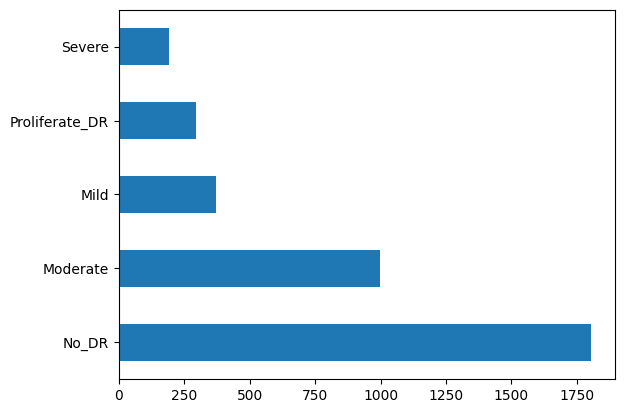

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

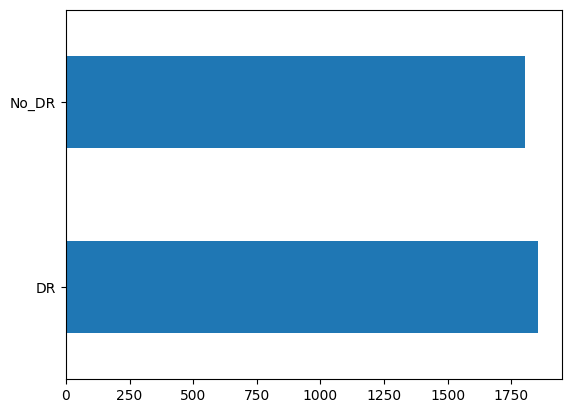

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [ ]:
# Copy images to respective working directory
src_dir = r'/content/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True,class_mode = 'categorical',batch_size = 5)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True,class_mode = 'categorical',batch_size = 5)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False,class_mode = 'categorical',batch_size = 5)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.InceptionV3(input_shape = (224, 224, 3),include_top = False,weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(2, activation='softmax')(x)
model_incep = tf.keras.models.Model(base_model.input, x)
model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),loss = 'categorical_crossentropy',metrics = ['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
mc1 = tf.keras.callbacks.ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );
call_back = [mc1];

In [ ]:
# Fitting the Model
incep = model_incep.fit(
    train_batches,
    steps_per_epoch = train_batches.samples//train_batches.batch_size,
    epochs = 32,
    validation_data = val_batches,
    validation_steps = val_batches.samples//val_batches.batch_size,
    callbacks = call_back
    )

Epoch 1/32
512/512 [==============================] - ETA: 0s - loss: 0.7667 - accuracy: 0.8928
Epoch 1: val_accuracy improved from -inf to 0.92545, saving model to ./ct_incep_best_model.hdf5
512/512 [==============================] - 37s 48ms/step - loss: 0.7667 - accuracy: 0.8928 - val_loss: 0.3415 - val_accuracy: 0.9255
Epoch 2/32
512/512 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.9331
Epoch 2: val_accuracy improved from 0.92545 to 0.96545, saving model to ./ct_incep_best_model.hdf5
512/512 [==============================] - 19s 36ms/step - loss: 0.3117 - accuracy: 0.9331 - val_loss: 0.2042 - val_accuracy: 0.9655
Epoch 3/32
512/512 [==============================] - ETA: 0s - loss: 0.2217 - accuracy: 0.9476
Epoch 3: val_accuracy did not improve from 0.96545
512/512 [==============================] - 17s 33ms/step - loss: 0.2217 - accuracy: 0.9476 - val_loss: 0.2299 - val_accuracy: 0.9600
Epoch 4/32
511/512 [============================>.] - ETA: 0s - los

In [ ]:
# Loading the Best Fit Model
from tensorflow.keras.models import load_model, Model
model_incep = load_model("./ct_incep_best_model.hdf5")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# Define path to test data
test_path = "/content/test"

# Load the saved best model
model_resnet = tf.keras.models.load_model('./ct_incep_best_model.hdf5')

# Make predictions on the test data
predictions = model_incep.predict(test_batches)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels
y_true = test_batches.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

# Generate classification report
target_names = ['class 0(dr)', 'class 1(non-dr)']
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=target_names))
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Overall accuracy: {:.2f}%".format(accuracy*100))


110/110 [==============================] - 2s 19ms/step
Confusion matrix:
[[267  12]
 [ 13 258]]
Classification report:
                 precision    recall  f1-score   support

    class 0(dr)       0.95      0.96      0.96       279
class 1(non-dr)       0.96      0.95      0.95       271

       accuracy                           0.95       550
      macro avg       0.95      0.95      0.95       550
   weighted avg       0.95      0.95      0.95       550

Overall accuracy: 95.45%


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = ResNet50(input_shape=(224, 224,3),
                      include_top=False, weights="imagenet",
                      pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(2, activation='sigmoid'))
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001),
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
    );

call_back = [mc];
# Fitting the Model
resnet = model_resnet.fit(
    train_batches,
    steps_per_epoch = train_batches.samples//train_batches.batch_size,
    epochs = 32,
    validation_data = val_batches,
    validation_steps = val_batches.samples//val_batches.batch_size,
    callbacks = call_back
    )

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/32
512/512 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.6996
Epoch 1: val_accuracy improved from -inf to 0.84909, saving model to ./ct_resnet_best_model.hdf5
512/512 [==============================] - 21s 35ms/step - loss: 0.6054 - accuracy: 0.6996 - val_loss: 0.4766 - val_accuracy: 0.8491
Epoch 2/32
512/512 [==============================] - ETA: 0s - loss: 0.4390 - accuracy: 0.8569
Epoch 2: val_accuracy improved from 0.84909 to 0.86182, saving model to ./ct_resnet_best_model.hdf5
512/512 [==============================] - 16s 31ms/step - loss: 0.4390 - accuracy: 0.8569 - val_loss: 0.3931 - val_accuracy: 0.8618
Epoch 3/32
512/512 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8619
Epoch 3: val_accuracy improved from 0.86182 to 0.86909, saving model to ./ct_resnet_best_model.hdf5
512/512 [==============================] - 16s 32ms/step - loss: 0.3951 - accuracy: 

In [ ]:
# Loading the Best Fit Model
model_resnet = load_model("./ct_resnet_best_model.hdf5")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# Define path to test data
test_path = "/content/test"

# Load the saved best model
model_resnet = tf.keras.models.load_model('./ct_incep_best_model.hdf5')

# Make predictions on the test data
predictions = model_resnet.predict(test_batches)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels
y_true = test_batches.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

# Generate classification report
target_names = ['class 0(dr)', 'class 1(non-dr)']
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=target_names))
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Overall accuracy: {:.2f}%".format(accuracy*100))


110/110 [==============================] - 3s 20ms/step
Confusion matrix:
[[267  12]
 [ 13 258]]
Classification report:
                 precision    recall  f1-score   support

    class 0(dr)       0.95      0.96      0.96       279
class 1(non-dr)       0.96      0.95      0.95       271

       accuracy                           0.95       550
      macro avg       0.95      0.95      0.95       550
   weighted avg       0.95      0.95      0.95       550

Overall accuracy: 95.45%


In [ ]:
resnet.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

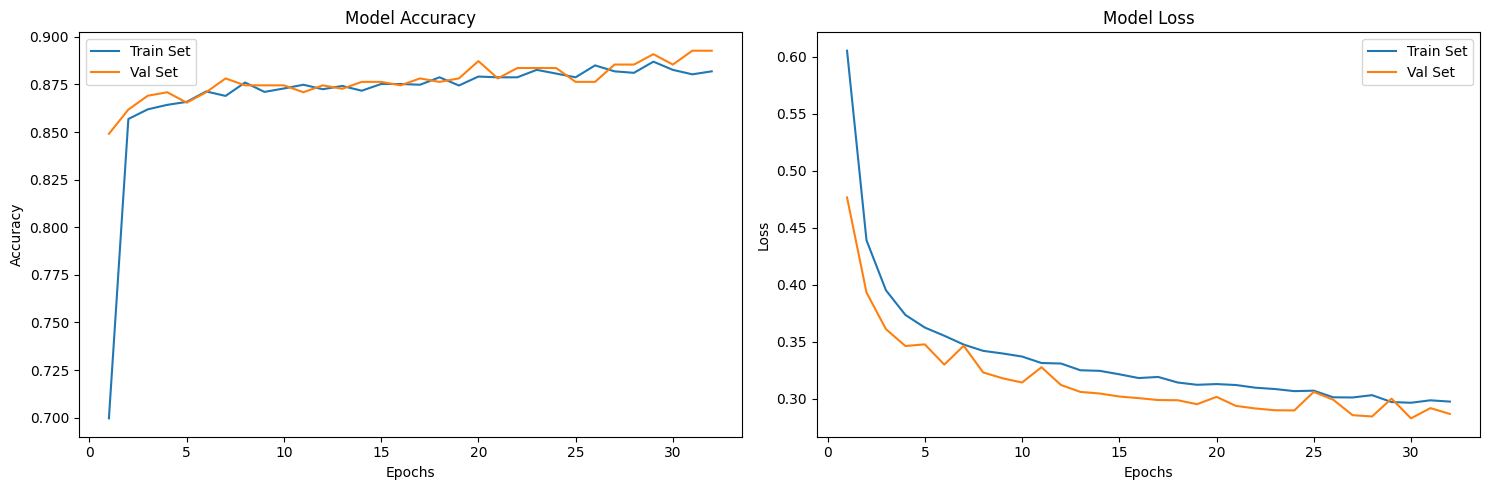

In [ ]:
# Plot model performance
acc = resnet.history['accuracy']
val_acc = resnet.history['val_accuracy']
loss = resnet.history['loss']
val_loss = resnet.history['val_loss']
epochs_range = range(1, len(resnet.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

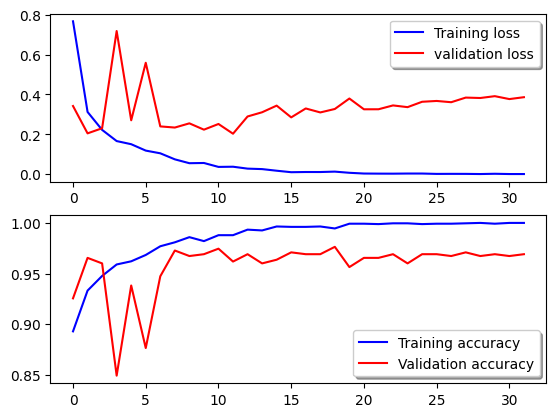

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(incep.history['loss'], color='b', label="Training loss")
ax[0].plot(incep.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(incep.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(incep.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
513/513 [==============================] - 15s 20ms/step - loss: 0.3439 - acc: 0.8837 - val_loss: 0.4952 - val_acc: 0.9036
Epoch 2/30
513/513 [==============================] - 9s 18ms/step - loss: 0.2420 - acc: 0.9145 - val_loss: 0.2459 - val_acc: 0.9182
Epoch 3/30
513/513 [==============================] - 10s 20ms/step - loss: 0.2065 - acc: 0.9141 - val_loss: 0.3230 - val_acc: 0.9182
Epoch 4/30
513/513 [==============================] - 10s 20ms/step - loss: 0.1971 - acc: 0.9145 - val_loss: 0.4251 - val_acc: 0.8582
Epoch 5/30
513/513 [==============================] - 10s 20ms/step - loss: 0.1325 - acc: 0.9356 - val_loss: 0.3236 - val_acc: 0.9000
Epoch 6/30
513/513 [==============================] - 11s 22ms/step - loss: 0.1198 - acc: 0.9340 - val_loss: 0.3531 - val_acc: 0.8782
Epoch 7/30
513/513 [==============================] - 9s 18ms/step - loss: 0.0932 - acc: 0.9375 - val_loss: 0.5454 - val_acc: 0.9000
Epoch 8/30
513/513 [==============================] - 9s 18ms/st

In [ ]:
model.save('/content/ct_cnn_best_model.hdf5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

# Define path to test data
test_path = "/content/test"

# Load the saved best model
model_resnet = tf.keras.models.load_model('/content/ct_cnn_best_model.hdf5')

# Make predictions on the test data
predictions = model.predict(test_batches)

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels
y_true = test_batches.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

# Generate classification report
target_names = ['class 0(dr)', 'class 1(non-dr)']
print("Classification report:")
print(classification_report(y_true, y_pred, target_names=target_names))
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Overall accuracy: {:.2f}%".format(accuracy*100))

110/110 [==============================] - 2s 14ms/step
Confusion matrix:
[[279   0]
 [163 108]]
Classification report:
                 precision    recall  f1-score   support

    class 0(dr)       0.63      1.00      0.77       279
class 1(non-dr)       1.00      0.40      0.57       271

       accuracy                           0.70       550
      macro avg       0.82      0.70      0.67       550
   weighted avg       0.81      0.70      0.67       550

Overall accuracy: 70.36%


In [ ]:
# Checking the Accuracy of the Model Resnet50
accuracy_resnet = model.evaluate_generator(generator= test_batches)[1]
print(f"The accuracy of the model is = {accuracy_resnet*100} %")
loss_model = test_score[0]
print(f"The loss of the model is = {loss_model} %")

<ipython-input-43-3d718f95248b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = model.evaluate_generator(generator= test_batches)[1]


The accuracy of the model is = 70.36363482475281 %
The loss of the model is = 0.573620080947876 %


In [ ]:
# Checking the Accuracy of the Model Resnet50
accuracy_resnet = model_resnet.evaluate_generator(generator= test_batches)[1]
print(f"The accuracy of the model is = {accuracy_resnet*100} %")
loss_resnet = test_score[0]
print(f"The loss of the model is = {loss_resnet} %")

<ipython-input-24-369249fa19c3>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = model_resnet.evaluate_generator(generator= test_batches)[1]


The accuracy of the model is = 95.45454382896423 %
The loss of the model is = 0.573620080947876 %


In [ ]:
# Checking the Accuracy of the Incep
accuracy_incep = model_incep.evaluate_generator(generator= test_batches)[1]
print(f"The accuracy of the model is = {accuracy_incep*100} %")
loss_incep = test_score[0]
print(f"The loss of the model is = {loss_incep} %")

<ipython-input-25-564b810c03bd>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = model_incep.evaluate_generator(generator= test_batches)[1]


The accuracy of the model is = 95.45454382896423 %
The loss of the model is = 0.573620080947876 %


In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

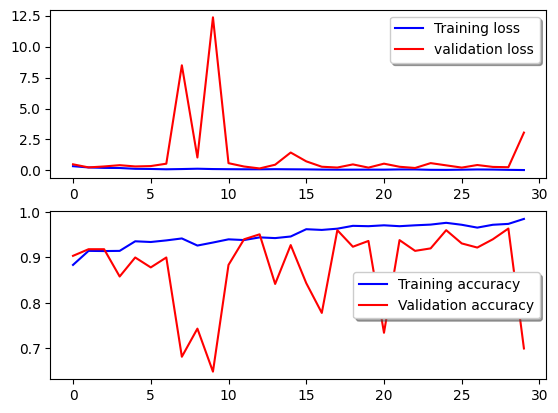

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

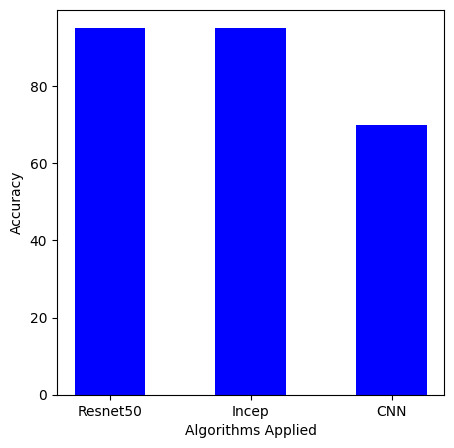

In [ ]:
algos = ['Resnet50','Incep','CNN']
accuracy = [accuracy_resnet, accuracy_incep,acc]
accuracy = np.floor([i * 100 for i in accuracy])

fig = plt.figure(figsize = (5, 5))
#fig.set_figwidth(4)

# creating the bar plot
plt.bar(algos, accuracy, color ='blue', width = 0.5)

plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("/content/ct_resnet_best_model.hdf5")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')




1/1 [==============================] - 1s 1s/step
DR


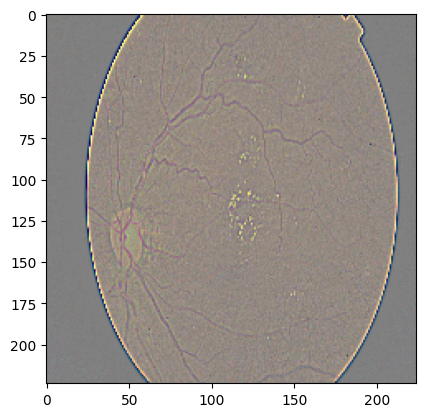

In [ ]:
predict_class('/content/test/DR/00a8624548a9.png')